# Homework

In [96]:
# Librerie 
import numpy as np
import matplotlib.pyplot as plt
import random 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

from copy import deepcopy

### Scaricato e analizzato il Dataset

In [3]:
# Dati
x_train = np.load("/kaggle/input/cifar10-hw3/cifar_hw3/x_train.npy")
x_val = np.load("/kaggle/input/cifar10-hw3/cifar_hw3/x_val.npy")
x_test = np.load("/kaggle/input/cifar10-hw3/cifar_hw3/x_test.npy")
y_train = np.load("/kaggle/input/cifar10-hw3/cifar_hw3/y_train.npy")
y_val = np.load("/kaggle/input/cifar10-hw3/cifar_hw3/y_val.npy")
y_test = np.load("/kaggle/input/cifar10-hw3/cifar_hw3/y_test.npy")

In [4]:
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)


(40000, 32, 32, 3) (40000, 1)
(10000, 32, 32, 3) (10000, 1)
(10000, 32, 32, 3) (10000, 1)


In [5]:
# Classi
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

In [6]:
y_train[1]

array([7], dtype=uint8)

In [35]:
# Funzione per visualizzare alcune immagini di ogni set di dati
def show_images(x, y, class_names, n=6, start=0):
    plt.figure(figsize=(15, 3))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(x[start + i])
        label = y[start + i][0] 
        plt.title(class_names[label])
        plt.axis('off')
    plt.show()

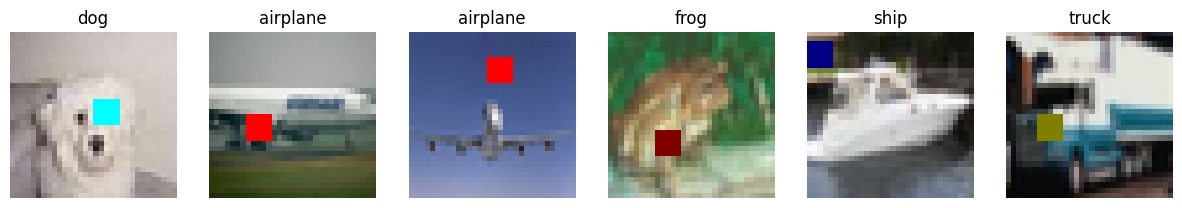

In [48]:
# Training images
show_images(x_train, y_train, class_names, start=16)

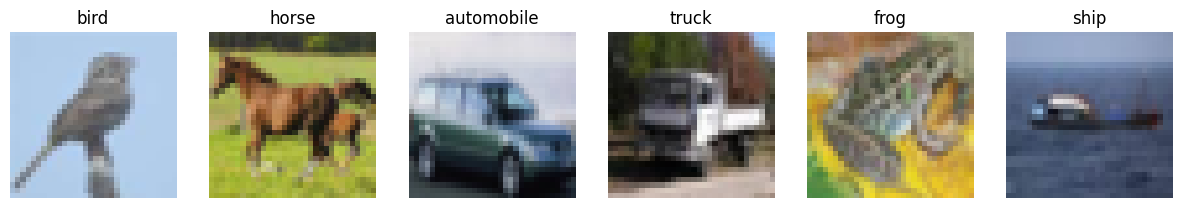

In [44]:
# Validation images
show_images(x_val, y_val, class_names)

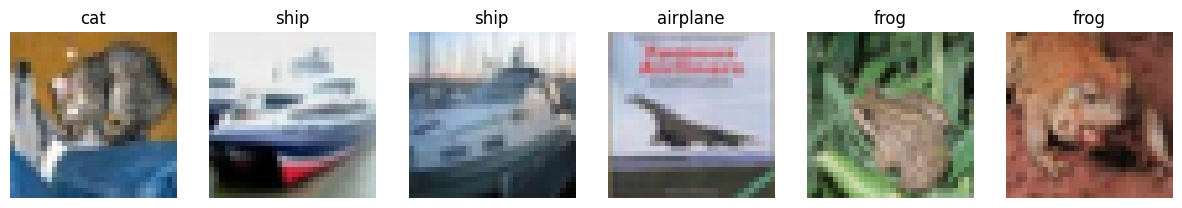

In [45]:
# Test images
show_images(x_test, y_test, class_names)

In [11]:
# Funzione per rilevare e rimuovere il rumore quadrato colorato da ogni immagine
def remove_colored_square(images, square_size=5):
    """
    Parametri:
    - images: np.ndarray (N, 32, 32, 3)
    - square_size: Dimensione del quadrato da rilevare e rimuovere

    Ritorna:
    - cleaned_images: np.ndarray della stessa forma con quadrato mascherato in nero
    """
    cleaned_images = images.copy()

    for idx, img in enumerate(images):
        found = False
        # Scansiona tutte le possibili finestre 5x5
        for y in range(32 - square_size + 1): # y e x => 0 to 27
            for x in range(32 - square_size + 1):
                patch = img[y:y+square_size, x:x+square_size, :] # RGB channels
                # Controlla se tutti i pixel nella patch hanno lo stesso colore (patch[0, 0, :] => first pixel)
                if np.all(patch == patch[0, 0, :]):
                    cleaned_images[idx, y:y+square_size, x:x+square_size, :] = 0
                    found = True
                    break
            if found:
                break
        # Se non è stato trovato alcun quadrato
        if not found:
            pass 
    
    return cleaned_images

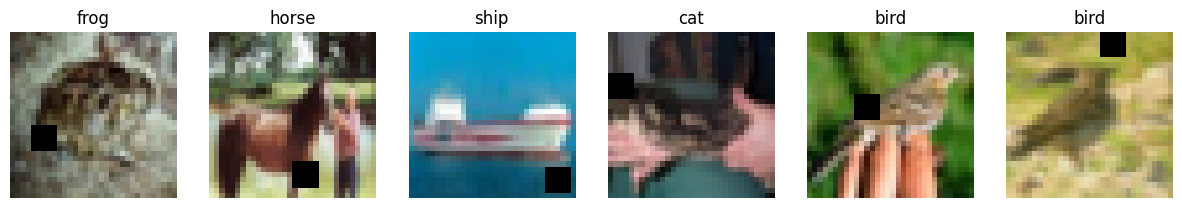

In [12]:
x_train_cleaned = remove_colored_square(x_train, square_size=5)
show_images(x_train_cleaned, y_train, class_names)

In [13]:
# Funzione per confrontare i dati di x_train originali con quelli "puliti"
def compare_original_vs_cleaned(x_original, x_cleaned, y, class_names, n=5, title="Original vs Cleaned"):
    # Estrai 5 indici casuali
    indices = np.random.choice(len(x_original), size=n, replace=False)
    
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(indices):
        
        # Original image
        plt.subplot(2, n, i+1)  # (row, column, index)
        plt.imshow(x_original[idx])
        label = y[idx][0]
        plt.title(f"Class: {class_names[label]}")
        plt.axis('off')
        
        # Cleaned image
        plt.subplot(2, n, n+i+1)
        plt.imshow(x_cleaned[idx])
        plt.axis('off')
    
    plt.suptitle(title)
    plt.show()


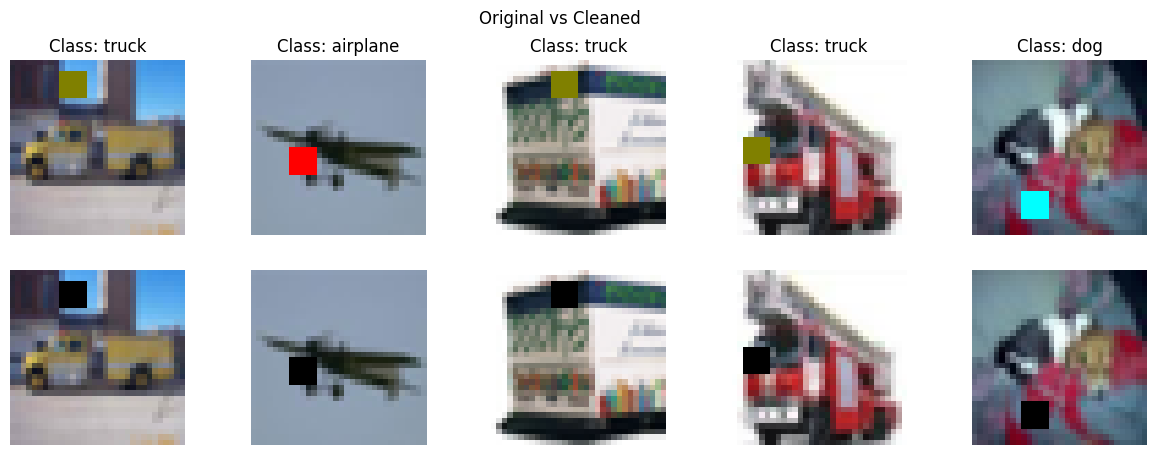

In [14]:
compare_original_vs_cleaned(x_train, x_train_cleaned, y_train, class_names)

### Preprocessing

In [15]:
# Funzione che applica il flatten e lo scaler
def preprocess_images(x):
    N = x.shape[0]
    x_flat = x.reshape(N, -1)   # Inserendo -1, viene calcolata automaticamente la dimensione rimanente
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(x_flat) # mean = 0, std = 1
    return x_scaled, scaler

In [16]:
print(x_train_cleaned.max(), x_train_cleaned.min())
print(x_val.max(), x_val.min())
print(x_test.max(), x_test.min())

255 0
255 0
255 0


In [17]:
# Preprocess sui dati di test "puliti"
x_train_proc, scaler = preprocess_images(x_train_cleaned)

# Applica lo scaler sui dati di validation e test
x_val_flat = x_val.reshape(x_val.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

x_val_proc = scaler.transform(x_val_flat)
x_test_proc = scaler.transform(x_test_flat)

In [18]:
print(x_train_proc.max(), x_train_proc.min())
print(x_val_proc.max(), x_val_proc.min())
print(x_test_proc.max(), x_test_proc.min())

2.596059971235476 -2.063645027885422
2.596059971235476 -2.063645027885422
2.596059971235476 -2.063645027885422


In [19]:
print(x_train_proc.shape)
print(x_val_proc.shape)
print(x_test_proc.shape)

(40000, 3072)
(10000, 3072)
(10000, 3072)


In [49]:
# Reduce il training set
x_small, _, y_small, _ = train_test_split(x_train_proc, y_train, train_size=0.50, stratify=y_train, random_state=42)

In [50]:
print(x_small.shape)
print(y_small.shape)

(20000, 3072)
(20000, 1)


### GridSearch

In [51]:
# Funzione che addestra un MLP utilizzando GridSearchCV
def train_mlp_with_gridsearch(x_train, y_train, cv=3):
    """
    Parametri:
    - x_train
    - y_train
    - cv: Numero di folds (default = 3)

    Ritorna:
    - best_model: MLPClassifier addestrato con i migliori parametri
    """
    
    param_grid = {
        'hidden_layer_sizes': [(512, 128, 64), (512, 256, 128, 64)],
        'activation': ['relu'],
        'solver': ['adam'],
        'alpha': [1e-4, 1e-3],  # L2 regularization
        'learning_rate_init': [0.001],
    }

    mlp = MLPClassifier(max_iter=50, random_state=42, early_stopping=True)

    grid = GridSearchCV(mlp, param_grid, cv=cv, scoring='accuracy', verbose=2, n_jobs=-1) 
    grid.fit(x_train, y_train.ravel())  # ravel() --> flatten

    print("Best parameters found:", grid.best_params_)
    print("\nClassification Report (Best Model):\n")
    print(classification_report(y_train, grid.predict(x_train)))

    return grid.best_estimator_

In [52]:
# Trova il migliore modello con i migliori iperparametri
best_mlp = train_mlp_with_gridsearch(x_small, y_small, cv=3)


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best parameters found: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (512, 256, 128, 64), 'learning_rate_init': 0.001, 'solver': 'adam'}

Classification Report (Best Model):

              precision    recall  f1-score   support

           0       0.85      0.86      0.85      2000
           1       0.92      0.92      0.92      2000
           2       0.87      0.74      0.80      2000
           3       0.82      0.72      0.77      2000
           4       0.78      0.84      0.81      2000
           5       0.85      0.79      0.82      2000
           6       0.71      0.93      0.80      2000
           7       0.94      0.82      0.88      2000
           8       0.87      0.92      0.89      2000
           9       0.88      0.90      0.89      2000

    accuracy                           0.84     20000
   macro avg       0.85      0.84      0.84     20000
weighted avg       0.85      0.84      0.84  

In [55]:
best_mlp

MLPClassifier(early_stopping=True, hidden_layer_sizes=(512, 256, 128, 64),
              max_iter=50, random_state=42)

In [56]:
# Valuta il modello MLP
y_val_pred = best_mlp.predict(x_val_proc)

# Stampare il classification report sul validation 
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.47      0.53      0.50      1000
           1       0.57      0.53      0.55      1000
           2       0.39      0.27      0.32      1000
           3       0.33      0.27      0.30      1000
           4       0.34      0.41      0.37      1000
           5       0.38      0.33      0.35      1000
           6       0.41      0.63      0.50      1000
           7       0.63      0.38      0.47      1000
           8       0.53      0.66      0.59      1000
           9       0.52      0.49      0.50      1000

    accuracy                           0.45     10000
   macro avg       0.46      0.45      0.44     10000
weighted avg       0.46      0.45      0.44     10000

[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(512, 128, 64), learning_rate_init=0.001, solver=adam; total time= 6.0min
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(512, 128, 64), learning_rate_init=0.001, solver=a

### Training Process

In [57]:
mlp_early_stop = MLPClassifier(
    hidden_layer_sizes=(512, 256, 128, 64),
    max_iter=1,                    # Una sola epoca per volta
    activation='relu',
    solver='adam',
    alpha=0.0001,
    learning_rate_init=0.001,
    verbose=False,
    random_state=42,
    warm_start=True               # Continua il training process dall'ultimo stato
)

In [62]:
y_train = y_train.ravel()
y_val = y_val.ravel()
y_test = y_test.ravel()


In [67]:
# Parametri early stopping
n_total_epochs = 100  
patience = 10         
tolerance = 1e-4      
best_val_accuracy = 0.0
epochs_without_improvement = 0
best_epoch = 0
best_model = None

# Loop --> epoche da 1 a 100
for epoch in range(1, n_total_epochs + 1):
    
    # Allena per una singola epoca
    mlp_early_stop.fit(x_train_proc, y_train)
    
    # Calcola accuracy su train e validation
    train_pred = mlp_early_stop.predict(x_train_proc)
    val_pred = mlp_early_stop.predict(x_val_proc)
    
    train_acc = accuracy_score(y_train, train_pred)
    val_acc = accuracy_score(y_val, val_pred)
    
    
    # Confronta l'accuracy di questa epoca con la migliore accuracy
    improvement = val_acc - best_val_accuracy

    # Il modello migliora
    if improvement > tolerance:
        best_val_accuracy = val_acc
        epochs_without_improvement = 0
        best_epoch = epoch
        best_model = deepcopy(mlp_early_stop)
        print(f"Epoca {epoch}: Nuova best accuracy: {best_val_accuracy:.4f}")

    # Nessun miglioramento significativo
    else:
        epochs_without_improvement += 1
        print(f"Epoca {epoch}: Nessun miglioramento: {epochs_without_improvement}/{patience}")
        # Attivazione early stopping se otteniamo 10 epoche senza miglioramento
        if epochs_without_improvement >= patience:
            print(f"Best validation accuracy: {best_val_accuracy:.4f} (epoca {best_epoch})")
            print(f"Training interrotto all'epoca {epoch}")
            break


Epoca 1: Nuova best accuracy: 0.4659
Epoca 2: Nuova best accuracy: 0.4664
Epoca 3: Nessun miglioramento: 1/10
Epoca 4: Nuova best accuracy: 0.4684
Epoca 5: Nuova best accuracy: 0.4716
Epoca 6: Nessun miglioramento: 1/10
Epoca 7: Nessun miglioramento: 2/10
Epoca 8: Nuova best accuracy: 0.4721
Epoca 9: Nuova best accuracy: 0.4728
Epoca 10: Nessun miglioramento: 1/10
Epoca 11: Nessun miglioramento: 2/10
Epoca 12: Nessun miglioramento: 3/10
Epoca 13: Nessun miglioramento: 4/10
Epoca 14: Nessun miglioramento: 5/10
Epoca 15: Nessun miglioramento: 6/10
Epoca 16: Nessun miglioramento: 7/10
Epoca 17: Nuova best accuracy: 0.4756
Epoca 18: Nessun miglioramento: 1/10
Epoca 19: Nuova best accuracy: 0.4775
Epoca 20: Nessun miglioramento: 1/10
Epoca 21: Nuova best accuracy: 0.4784
Epoca 22: Nessun miglioramento: 1/10
Epoca 23: Nessun miglioramento: 2/10
Epoca 24: Nessun miglioramento: 3/10
Epoca 25: Nessun miglioramento: 4/10
Epoca 26: Nessun miglioramento: 5/10
Epoca 27: Nuova best accuracy: 0.4800


### Valuta il modello

In [71]:
# Test del modello sul set di test
y_test_pred = best_model.predict(x_test_proc)

# Stampare il classification report sul test 
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.50      0.55      0.52      1000
           1       0.60      0.57      0.58      1000
           2       0.34      0.40      0.37      1000
           3       0.31      0.21      0.25      1000
           4       0.41      0.38      0.40      1000
           5       0.36      0.37      0.37      1000
           6       0.52      0.55      0.53      1000
           7       0.59      0.52      0.55      1000
           8       0.54      0.70      0.61      1000
           9       0.52      0.47      0.49      1000

    accuracy                           0.47     10000
   macro avg       0.47      0.47      0.47     10000
weighted avg       0.47      0.47      0.47     10000



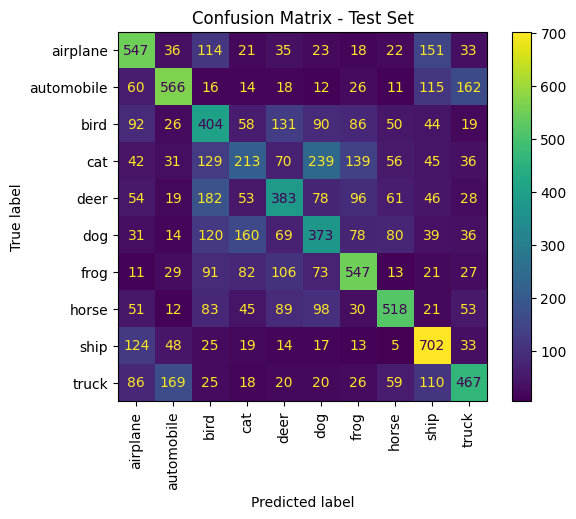

In [115]:
# Stampare la confusion matrix sul test 
cm = confusion_matrix(y_test, y_test_pred)

# Visualizza la matrice
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
cm_display.plot(xticks_rotation='vertical')
plt.title("Confusion Matrix - Test Set")
plt.show()

In [122]:
# Errori
errors = np.where(y_test != y_test_pred)[0]
len(errors)

5280

In [127]:
# Funzione che mostra le immagini del test set con predizione errata
def show_misclassified_images(x, y_true, y_pred, class_names, n=5):
    
    errors = np.where(y_true != y_pred)[0]
    # Estrai casualmente n errori
    random_errors = np.random.choice(errors, size=n, replace=False)

    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(random_errors):
        plt.subplot(1, n, i + 1)
        plt.imshow(x[idx])
        true_label = class_names[y_true[idx]]
        pred_label = class_names[y_pred[idx]]
        plt.title(f"True: {true_label}\nPred: {pred_label}")
        plt.axis('off')
        
    plt.tight_layout() # Ottimizza la spaziatura tra le immagini.
    plt.show()


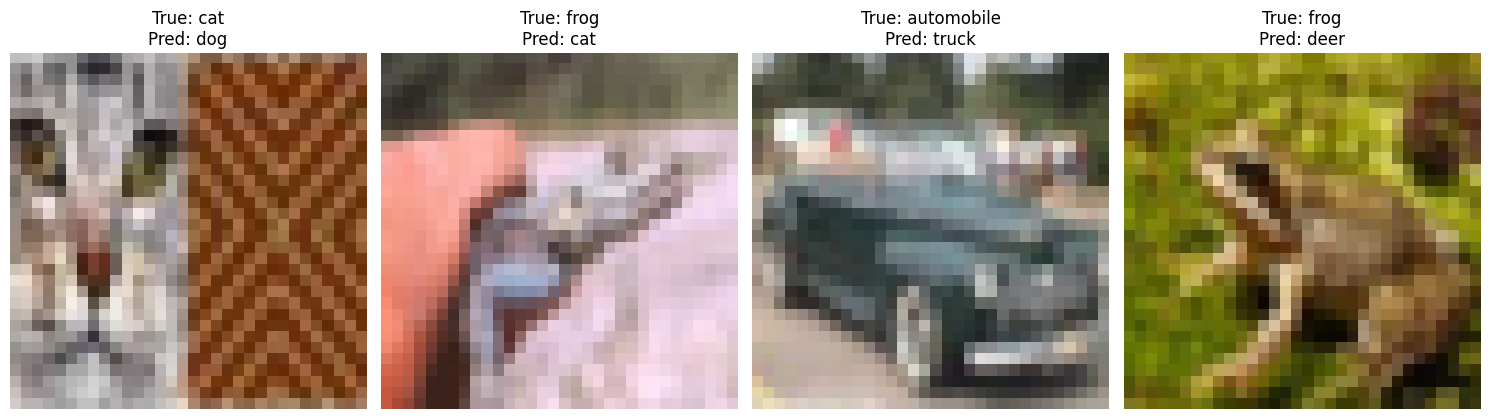

In [129]:
show_misclassified_images(x_test, y_test.ravel(), y_test_pred, class_names, n=4)


### Conclusioni

In questo progetto è stato affrontato un problema di classificazione su un dataset derivato da CIFAR-10, modificato in modo da introdurre un rumore nel training set: un quadrato colorato specifico per ogni classe. Tale rumore portava a un rischio elevato di overfitting, poiché il modello poteva imparare a classificare basandosi sul colore del quadratino piuttosto che sul contenuto reale dell’immagine (Shortcut learning).

Per affrontare questa problematica, è stata progettata una pipeline con i seguenti passaggi principali:

- **Rimozione automatica dei quadrati colorati** .
- **Preprocessing** delle immagini tramite flattening e standardizzazione (mean=0, std=1).
- **Selezione del modello** MLP attraverso GridSearchCV
- **Addestramento completo** con early stopping manuale su validation set, per evitare sovra-adattamento.
- **Valutazione finale** delle prestazioni su validation e test set, analizzando accuracy, report di classificazione e confusion matrix.

### Risultati

- **Best validation accuracy**: 48.37%
- **Test accuracy**: 47.00%
- Migliori prestazioni ottenute sulla classe (8 = ship), mentre altre (es. classe 3 = cat) risultano più difficili da distinguere.

### Considerazioni finali

Il modello ha mostrato una discreta capacità di generalizzazione. Per ottenere un miglior modello si potrebbe realizzare una CNN con dropout con framework come PyTorch o TensorFlow.
